In [53]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

from tqdm.notebook import tqdm

torch.set_default_dtype(torch.float32)

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,)),])

In [3]:
trainset = datasets.MNIST('train', download=True, train=True, transform=transform)
testset = datasets.MNIST('test', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [4]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


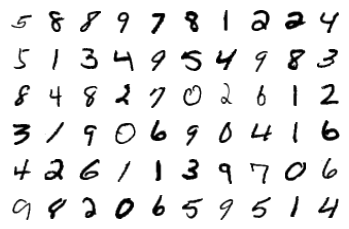

In [5]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [94]:
def print_test_accuracy(model, samples=None):
    correct_count, all_count = 0., 0.
    
    pbar = tqdm(testloader)
    for X, y in pbar:
        X = X.view(X.shape[0], -1)
        with torch.no_grad():
            ps = model(X).exp()
        yp = ps.argmax(dim=1)
        correct_count += (y==yp).sum()
        all_count += y.shape[0]
        
        pbar.set_description(f'Running Accuracy: ({correct_count/all_count : .03f})')
        
        if samples is not None and all_count>samples:
            break
    print("Number Of Images Tested =", all_count)
    print("\nModel Accuracy =", (correct_count/all_count))

In [95]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


In [96]:
print_test_accuracy(model)


Number Of Images Tested = 10000.0

Model Accuracy = tensor(0.0971)


In [98]:
optimizer = optim.Adam(model.parameters(), lr=0.003)
criterion = nn.NLLLoss()
time0 = time()
epochs = 3
for e in range(epochs):
    running_loss = 0
    for images, labels in tqdm(trainloader):
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        optimizer.zero_grad()        
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)


Epoch 0 - Training loss: 0.3384947147228316



Epoch 1 - Training loss: 0.17238523772578124



Epoch 2 - Training loss: 0.1399353466087035

Training Time (in minutes) = 0.860323949654897


In [99]:
print_test_accuracy(model)


Number Of Images Tested = 10000.0

Model Accuracy = tensor(0.9600)


In [118]:
class Model():
    def __init__(self, num_states, connectivity, num_inputs, num_outputs):
        self.num_states = num_states
        self.inds = []
        self.weights = []
        for i in range(num_states):
            ind = torch.randperm(num_states)[:connectivity]
            self.inds.append(ind)
            self.weights.append(torch.zeros_like(ind, dtype=torch.float32))
        self.inds = torch.stack(self.inds)
        self.weights = torch.stack(self.weights).requires_grad_()
        self.input_ind = torch.randperm(num_states)[:num_inputs]
        self.output_ind = torch.randperm(num_states)[:num_outputs]
        
    def __call__(self, X, updates=10):
        state = torch.zeros(X.shape[0], self.num_states)
        state[:, self.input_ind] = X
        for update in range(updates):
#             new_state = torch.zeros(X.shape[0], self.num_states)
#             for state_i in range(self.num_states):
#                 new_state[:, state_i] = state[:, self.inds[state_i]] @ self.weights[state_i]

            new_state = (state[:, self.inds] * self.weights).sum(dim=-1)
            state = new_state
        return state[:, self.output_ind]
    
    def parameters(self):
        return [self.weights]
    
ac_model = Model(784+128+64+10, 100, 784, 10)



In [119]:
print_test_accuracy(ac_model, samples=1000)


Number Of Images Tested = 1024.0

Model Accuracy = tensor(0.1113)


In [120]:
optimizer = optim.Adam(ac_model.parameters(), lr=0.003)
criterion = nn.NLLLoss()
time0 = time()
epochs = 3
for e in range(epochs):
    running_loss = 0
    for images, labels in tqdm(trainloader):
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        optimizer.zero_grad()        
        output = ac_model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

KeyboardInterrupt: 

In [121]:
print_test_accuracy(ac_model, samples=1000)


Number Of Images Tested = 1024.0

Model Accuracy = tensor(0.1064)
